# Tratamiento de imágenes - 2023 - Entregable 2

# Fecha de entrega: 13/5/2023


### Importante:

En todos los ejercicios se espera que se entregue comentarios sobre decisiones tomadas en la implementación así como un análisis de los resultados. Estos comentarios y análisis se pueden entregar en celdas de texto agregadas a los notebooks o en un informe aparte.

Para la entrega se sube un **zip** (no rar, ni otro formato) con:

-   El notebook del entregable modificado. El notebook debe tener las celdas ejecutadas con las salidas correspondientes. Debe tener todo lo necesario para poder ser ejecutado nuevamente
-   Todo el resto del contenido del zip del entregable. Si, para mostrar resultados, usan en el notebook imágenes propias, deben incluirlas en la carpeta **imagenes** del zip.
-   El informe en pdf en caso de no incluir las discusiones dentro del notebook en celdas "Markdown", o si les resulta más sencillo realizar el análisis en un documento aparte.

No se deben incluir en el zip de la entrega las imágenes de prueba que están disponibles en la página web del curso. Se asumirá que esas imágenes están en un directorio y se hará referencia a dichas imágenes en forma relativa a ese directorio (ver la celda siguiente).


In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imsave
import cv2
import scipy
import skimage

# FORMAS DE VER LAS GRAFICAS --------------------
# ELEGIR UNA DE LAS OPCIONES Y DES-COMENTAR (sacar # de la linea)
# ----------------
# a) graficas en línea  entre las celdas (no interactivo)
%matplotlib inline
# ----------------
# b) graficas en línea  entre las celdas (interactivo)
# %matplotlib notebook
# ----------------
# c) graficas en ventanas externas (abre una ventana por cada figura)
# %matplotlib
# ----------------
# d) Si se usa "jupyter lab" en lugar de "jupyter notebook" usar %matplotlib widget en lugar de %matplotlib notebook
# requiere instalar el modulo "ipympl". Ver https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab#56416229
# %matplotlib widget
# ---------------------------------------------------

# Directorio con la base de imágenes de prueba (las que están en la web de Timag)
# Ej. si usan la imagen trapo.jpg en el notebook no tienen que subirla al eva
# La llaman en el notebook en forma relativa a donde tengan esas imagenes:
#
# filename = os.path.join(dir_base_imagenes, 'trapo.jpg')
# I = imread(filename)
dir_base_imagenes = "../../../imagenes/"
dir_zip_imagenes = "./imagenes/"

# Directorio con la base de imágenes de documentos (para el ejercicio 5)
# En el notebook acceden a esos datos en forma relativa a donde tengan esas imagenes:
#
# filename = os.path.join(dir_base_documentos, '0012183661.tif')
# I = imread(filename)
dir_base_documentos = "./base_documentos"  # uncompressed before running

## Transformaciones geométricas


### 1. Implementar una función que realice transformaciones proyectivas


In [2]:
def bilineal(I, punto, color_de_fondo):
    """
    Dado un punto de coordenadas no necesariamente enteras y una imagen I,
    retorna la interpolación bilineal entre los cuatro pixeles de I más cercanos
    al punto de entrada.

    Args:
    - I (array 2D): Imagen de referencia para interpolar.
    - punto (tuple/list): coordenadas en imagen en formato: punto = (fila,columna) ó punto = [fila,columna]
    - color_de_fondo (int): en caso de que el punto está fuera de las dimensiones de la imagen,
    se le asigna este valor por defecto.

    Returns:
    valor_interpolado (int): valor interpolado en escala de grises para el punto.
    """
    # Calcular las coordenadas de los cuatro puntos vecinos
    x, y = punto
    x1, y1 = int(x), int(y)
    x2, y2 = x1 + 1, y1 + 1

    if x1 < 0 or x2 >= I.shape[0] or y1 < 0 or y2 >= I.shape[1]:
        return color_de_fondo

    # Calcular los valores de los cuatro pixeles más cercanos. Q_ij = (x_i, y_j)
    Q11, Q12, Q21, Q22 = I[x1, y1], I[x1, y2], I[x2, y1], I[x2, y2]

    # distancias entre el punto y los pixeles más cercanos
    x2_x, x_x1 = x2 - x, x - x1
    y2_y, y_y1 = y2 - y, y - y1

    return (
        Q11 * (x2_x) * (y2_y)
        + Q21 * (x_x1) * (y2_y)
        + Q12 * (x2_x) * (y_y1)
        + Q22 * (x_x1) * (y_y1)
    ) / ((x2 - x1) * (y2 - y1))


def vecino(I, punto, color_de_fondo):
    """
    Dado un punto de coordenadas no necesariamente enteras y una imagen I,
    retorna el nivel de gris correspondiente al pixel más cercano I.

    Args:
    - I (array 2D): Imagen de referencia para interpolar.
    - punto (tuple/list): coordenadas en imagen en formato: punto = (fila,columna) ó punto = [fila,columna]
    - color_de_fondo (int): en caso de que el punto está fuera de las dimensiones de la imagen,
    se le asigna este valor por defecto.

    Returns:
    valor_interpolado (int): valor interpolado en escala de grises para el punto.
    """
    # Coordenadas del pixel más cercano
    x, y = np.round(punto).astype(int)

    # Verificar si el pixel está dentro de las dimensiones de la imagen
    if x < 0 or x >= I.shape[0] or y < 0 or y >= I.shape[1]:
        return color_de_fondo

    # Devolver el valor del pixel más cercano
    valor_interpolado = I[x, y]

    return valor_interpolado


def transformar(I, T, tipo_interpolacion="vecino", color_de_fondo=0):
    """
    Aplicar una transformacion geometrica T a imagen I, especificando el tipo de interpolacion.

    Args:
    - I (array 2D): imagen a transformar.
    - T (array 2D): matriz de transformacion de tamaño 3x3.
    - tipo_interpolacion (str): interpolación a utilizar: 'vecino' más cercano (default) o 'bilineal'.
    - color_de_fondo (int): en caso de que el punto está fuera de las dimensiones de la imagen,
    se le asigna este valor por defecto.

    Returns:
    I_transformada (array 2D): imagen transformada

    """
    alto, ancho = I.shape

    # Inicializar la imagen de salida con el valor de fondo especificado
    I_transformada = np.full((alto, ancho), color_de_fondo, dtype=np.uint8)

    # Invertir la matriz de transformación para obtener la transformación inversa
    T_inv = np.linalg.inv(T)

    interpolacion = vecino if tipo_interpolacion == "vecino" else bilineal

    # Recorrer cada píxel de la imagen de salida
    for y, x in np.ndindex(I_transformada.shape):
        # vec_transformado = transformacion(vec) = T @ vec , donde T es la matriz de transformacion
        # Obtener las coordenadas de origen correspondientes en la imagen de entrada
        punto_origen = np.dot(T_inv, np.array([y, x, 1]))
        # Interpolar el valor del píxel utilizando el método especificado
        I_transformada[y, x] = interpolacion(I, punto_origen[:2], color_de_fondo)

    return I_transformada

#### Prueba con scipy


In [9]:
fondo = 0
zs = np.array([[1, 2], [3, 4]])
scipy_bilinear = scipy.interpolate.interp2d(
    [0, 1], [0, 1], zs, kind="linear", fill_value=fondo
)
eval_points = np.random.rand(3, 2)  # [[0.23,0.42], [0.56,0.11], [0.78,0.99]]
for point in eval_points:
    print(
        f"Punto:({point}), Bilineal: {bilineal(zs, point, fondo):.4f}, Scipy: {scipy_bilinear(point[1], point[0])}"
    )

Punto:([0.49904197 0.90517624]), Bilineal: 2.9033, Scipy: [2.90326017]
Punto:([0.63198365 0.02179229]), Bilineal: 2.2858, Scipy: [2.28575959]
Punto:([0.53361644 0.61112027]), Bilineal: 2.6784, Scipy: [2.67835315]


### 2. Usando la función transformar, mostrar ejemplos de transformaciones isométricas, afines y proyectivas con diferentes interpolaciones

Parecido a lo que se muestra en estos ejemplos de scikit-image:  
https://scikit-image.org/docs/stable/auto_examples/transform/plot_transform_types.html


In [154]:
trapecio = imread(f"{dir_zip_imagenes}trapecio.png", as_gray=True)
trapecio = (trapecio * 255).astype(np.uint8)

In [11]:
def compare_interpolations(imgs):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
    for ax, img, title in zip(
        axes.flatten(), imgs, ["Original", "Bilineal", "Vecino más cercano"]
    ):
        ax.imshow(img, cmap="gray")
        ax.set_title(title)
    plt.show()

#### Mostrar una rotación con origen en vértice superior izquierdo de la imagen (origen de coordenadas)


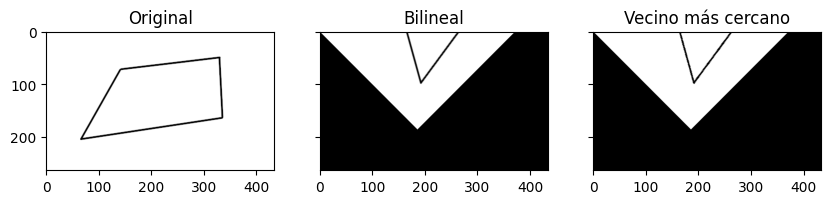

In [14]:
img = trapecio
theta = np.deg2rad(45)
rotacion = np.array(
    [[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]]
)

tfs_trapecio_vecino = transformar(img, rotacion, tipo_interpolacion="vecino")
tfs_trapecio_bilineal = transformar(img, rotacion, tipo_interpolacion="bilineal")

compare_interpolations([img, tfs_trapecio_bilineal, tfs_trapecio_vecino])

#### Mostrar una rotación con origen en el centro de la imagen

La transformación de rotación en el centro de la imagen puede calcularse como la composición de una traslación, una rotación y una traslación.


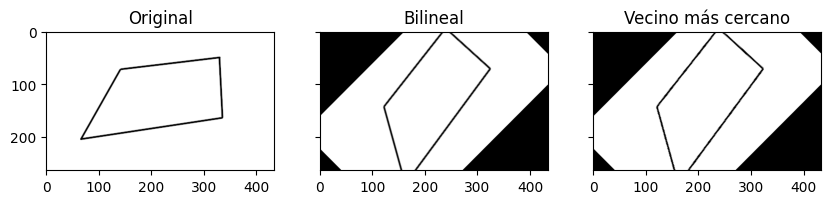

In [13]:
## Muestre las matrices correspondientes a las tres transformaciones
# matriz de traslación que mueve el centro de la imagen al origen (0,0)
w, h = trapecio.shape
T1 = np.array([[1, 0, -w / 2], [0, 1, -h / 2], [0, 0, 1]])
# matriz de rotación alrededor del origen
theta_rad = np.deg2rad(45)
R = np.array(
    [
        [np.cos(theta_rad), -np.sin(theta_rad), 0],
        [np.sin(theta_rad), np.cos(theta_rad), 0],
        [0, 0, 1],
    ]
)
# otra matriz de traslación que mueva el origen de vuelta al centro de la imagen
T2 = np.array([[1, 0, w / 2], [0, 1, h / 2], [0, 0, 1]])

## Calcule la matriz de rotación en el centro como la composición de las tres transformaciones anteriores
T_completa = T2 @ R @ T1

compare_interpolations(
    [
        trapecio,
        transformar(trapecio, T_completa, tipo_interpolacion="bilineal"),
        transformar(trapecio, T_completa, tipo_interpolacion="vecino"),
    ]
)

#### Mostrar una transformación afin


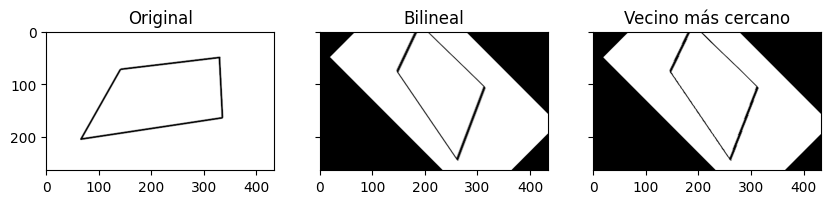

In [15]:
dx, dy = 50, 20  # traslación
sx, sy = 1.5, 0.5  # escala
theta = np.pi / 4  # 45 grados

T = np.array([[1, 0, dx], [0, 1, dy], [0, 0, 1]])

S = np.array([[sx, 0, 0], [0, sy, 0], [0, 0, 1]])

R = np.array(
    [[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]]
)

A = T @ R @ S

compare_interpolations(
    [
        trapecio,
        transformar(trapecio, A, tipo_interpolacion="bilineal"),
        transformar(trapecio, A, tipo_interpolacion="vecino"),
    ]
)

#### Mostrar una transformación proyectiva


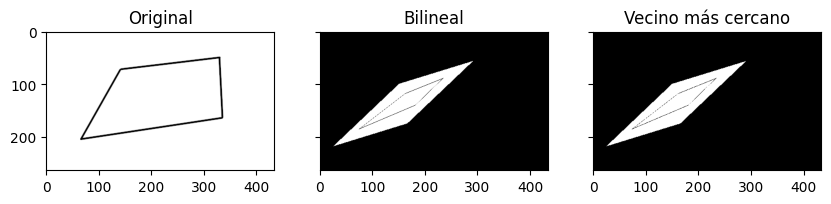

In [16]:
H = np.array([[0.7, -0.05, 100], [-0.1, 0.4, 150], [0.0025, 0.0005, 1]])
compare_interpolations(
    [
        trapecio,
        transformar(trapecio, H, tipo_interpolacion="bilineal"),
        transformar(trapecio, H, tipo_interpolacion="vecino"),
    ]
)

### 3. Implementar el cálculo de una matriz de transformación proyectiva a partir de un conjunto de 4 o más puntos correspondientes

Para chequear su implementación se puede comparar el resultado con cv2.findHomography por ejemplo


In [127]:
import itertools


def aplicar_homografia(H, origen):
    # agregar columna de 1s al final (homogeneizacion de los puntos)
    homog_origen = np.vstack((origen.T, np.ones((1, origen.shape[0]))))
    # aplicar la homografia
    homog_transformed = H @ homog_origen
    # convertir a coordenadas cartesianas (2d)
    return homog_transformed[:2, :] / homog_transformed[2, :]


# Entradas:
#    puntosA   Nx2
#    puntosB   Nx2
#    con N>=4
# Salida
#    H         3x3
def calcular_homografia_aux(puntosA, puntosB):
    # Construir la matriz de ecuaciones lineales
    num_puntos = len(puntosA)
    A = np.zeros((2 * num_puntos, 9))
    for i in range(num_puntos):
        x, y = puntosA[i]
        u, v = puntosB[i]
        A[2 * i] = [-x, -y, -1, 0, 0, 0, x * u, y * u, u]
        A[2 * i + 1] = [0, 0, 0, -x, -y, -1, x * v, y * v, v]
    # Resolver el sistema de ecuaciones lineales mediante descomposición en valores singulares (SVD)
    U, S, V = np.linalg.svd(A)
    # Obtenemos el vector propio correspondiente al valor propio más pequeño
    H = (V[-1, :] / V[-1, -1]).reshape(3, 3)
    # Normalizamos la matriz dividiendo por el último elemento
    H /= H[2, 2]
    return H


def calcular_homografia(puntosA, puntosB):
    best_H, best_error = None, np.inf
    # si N no es muy grande, podemos probar todas las combinaciones y quedarnos con la mejor
    combinations = itertools.combinations(range(len(puntosA)), 4)
    for indices in combinations:
        indices = list(indices)
        sample_A, sample_B = puntosA[indices], puntosB[indices]
        # Obtener homografia basado en 4 puntos
        H = calcular_homografia_aux(sample_A, sample_B)
        # Distancia de los puntos origen transformados por la homografía a los puntos destino
        transformed = aplicar_homografia(H, puntosA)
        error = np.linalg.norm(transformed.T - puntosB)
        # Actualizar la mejor homografía
        if error < best_error:
            best_error = error
            best_H = H
    return best_H

#### Chequear la función implementada


In [129]:
## chequear la función calcularHomografía con un conjunto de puntos N=4
origen = np.array([(0, 0), (0, 100), (100, 100), (100, 0)])
destino = np.array([(0, 0), (0, 100), (100, 50), (100, 0)])

## calcular la homografía
H1 = calcular_homografia(origen, destino)

## aplicar a los puntos origen y verificar si el resultado son los puntos destino
transformed_H1 = aplicar_homografia(H1, origen)
# Print the transformed points and the original points for comparison
print("calcular_homografia\n", np.round(transformed_H1))
print(
    f"metricas: close={np.allclose(transformed_H1, destino.T)} norm={np.linalg.norm(transformed_H1-destino.T):.5f}"
)
print("destino\n", destino.T)

calcular_homografia
 [[  0.   0. 100. 100.]
 [  0. 100.  50.  -0.]]
metricas: close=True norm=0.00000
destino
 [[  0   0 100 100]
 [  0 100  50   0]]


In [124]:
## chequear la función calcularHomografía con un conjunto de puntos N>4
origen = np.array([(0, 0), (0, 52), (0, 100), (100, 100), (100, 0)])
destino = np.array([(0, 0), (0, 48), (0, 100), (100, 50), (100, 0)])

## calcular la homografía
H1 = calcular_homografia(origen, destino)
H2, _ = cv2.findHomography(origen, destino)

## aplicar a los puntos origen y verificar si el resultado son los puntos destino
transformed_H1 = aplicar_homografia(H1, origen)
transformed_H2 = aplicar_homografia(H2, origen)

# Print the transformed points and the original points for comparison
print("calcular_homografia\n", np.round(transformed_H1))
print(
    f"metricas: close={np.allclose(transformed_H1, destino.T)} norm={np.linalg.norm(transformed_H1-destino.T):.5f}"
)
print("find_homography\n", np.round(transformed_H2))
print(
    f"metricas: close={np.allclose(transformed_H2, destino.T)} norm={np.linalg.norm(transformed_H2-destino.T):.5f}"
)
print("destino\n", destino.T)

calcular_homografia
 [[  0.   0.   0. 100. 100.]
 [  0.  52. 100.  50.  -0.]]
metricas: close=False norm=4.00000
find_homography
 [[  0.   0.  -0. 101.  99.]
 [ -1.  50.  99.  50.   0.]]
metricas: close=False norm=2.75118
destino
 [[  0   0   0 100 100]
 [  0  48 100  50   0]]


## Segmentación


### 4. Detección de líneas con la transformada de Hough


Se puede encontrar una buena explicación y pseudocódigo en los libros de [Burger & Burge](https://books.google.com.uy/books?id=YpzWCwAAQBAJ&printsec=frontcover#v=onepage&q&f=false).  
Se sugiere seguir dicho pseudocódigo para la implementación.


#### Dibujo de líneas


In [15]:
def plot_lineas_hough(ax, L, centrar=True):
    """
    Grafica sobre la figura especificada las líneas definidas en L

    Args
    ----
    ax : Eje de la figura de matplotlib donde se plotean las líneas
    L :   [[theta, rho, votos], [theta, rho, votos], .....]
          Lista de rectas detectadas con la función lineas_hough
    centrar : Si es True, traslada el 0,0 al centro del eje del grafico

    Returns
    -------
    Nothing
    """
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    # Asegura que la linea ocupe todo el grafico
    line_length = np.sqrt((xlim[1] - xlim[0]) ** 2 + (ylim[1] - ylim[0]) ** 2) * 2

    centro = lambda a, b, rho: (a * rho, b * rho)
    if centrar:
        # mitad del ancho y alto del grafico
        m, n = (xlim[1] - xlim[0]) / 2, (ylim[0] - ylim[1]) / 2
        # trasladar el punto (0,0) al centro de la imagen
        centro = lambda a, b, rho: (a * rho + m, b * rho + n)

    for theta, rho, _ in L:
        b, a = np.cos(theta), np.sin(theta)
        # coordenadas (x0, y0) correspondientes al punto en el que la línea cruza el origen de coordenadas (rho, theta).
        x0, y0 = centro(a, b, rho)
        # vector perpendicular a la línea original = (-b, a)
        # escalado a line_length pixeles
        x1, y1 = int(x0 - line_length * b), int(y0 + line_length * a)
        x2, y2 = int(x0 + line_length * b), int(y0 - line_length * a)

        ax.plot([x1, x2], [y1, y2])

    # esto es para que las lineas no modifiquen el tamaño del grafico
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

#### Mostrar el funcionamiento de plot_lineas_hough para distintos valores theta-rho

Notar que se puede implementar y probar **plot_lineas_hough** antes de implementar **lineas_hough**.  
Se sugiere dejar andando correctamente **plot_lineas_hough** primero. Esto permitirá luego probar rápidamente los resultados de **lineas_hough**.


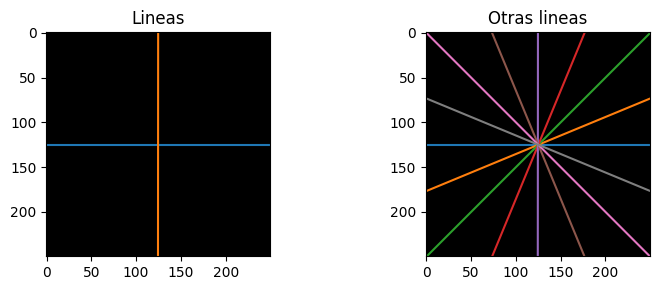

In [35]:
# Imagen vacía a plottear
zeros = np.zeros((250, 250))

# líneas horizontal y vertical que pasan por la mitad de la imagen
lineas = [[0, 0], [0, np.pi / 2]]
# lineas separadas por un ángulo de pi/8 radianes
lineas2 = [
    [0, 0],
    [0, np.pi / 8],
    [0, np.pi / 4],
    [0, 3 * np.pi / 8],
    [0, np.pi / 2],
    [0, 5 * np.pi / 8],
    [0, 3 * np.pi / 4],
    [0, 7 * np.pi / 8],
]

## Arreglar líneas para que sean compatibles con la función lineas_hough, [[theta, rho, votos], [theta, rho, votos], ...]
lineas = list(map(lambda x: [x[1], x[0], 1], lineas))
lineas2 = list(map(lambda x: [x[1], x[0], 1], lineas2))

# Inicializar figura
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# Plot lineas
ax[0].imshow(zeros, cmap="gray")
plot_lineas_hough(ax[0], lineas)
ax[0].set_title("Lineas")
# Plot lineas2
ax[1].imshow(zeros, cmap="gray")
plot_lineas_hough(ax[1], lineas2)
ax[1].set_title("Otras lineas")
fig.tight_layout()
plt.show()

Las imágenes de salida deberían ser del estilo:

![Alt text](imagenes/output_plot_hough.png)


#### Detección de líneas


In [153]:
def lineas_hough(I, m, n, minimo_votos, debug=False):
    """
    Detección de líneas mediante la Transformada de Hough

    Args
    ----
    I : imagen binaria (resultado de un detector de bordes por ejemplo)
    m, n : Enteros que determinan las dimensiones del acumulador
           m: cantidad de pasos en Theta
           n: cantidad de pasos en Rho
    minimo_votos : Cantidad mínima de votos que debe tener una recta
    debug : Booleano opcional. En caso de ser verdadero, se muestra la imagen del acumulador

    Returns
    -------
    L : [[theta, rho, votos], [theta, rho, votos], .....]
        Lista con las rectas detectadas donde cada elemento de la lista es una terna [theta, rho, votos]
        La lista está ordenada en forma decreciente en la cantidad de votos

    """
    height, width = I.shape
    x_r, y_r = height / 2, width / 2
    d_theta, d_rho = np.pi / m, np.sqrt(height**2 + width**2) / n
    j_0 = int(np.ceil(n / 2))

    ## Inicializacion y llenado del acumulador
    acumulador = np.zeros((m, n))
    # Precomputo de los valores de coseno y seno, permite evitar el for sobre m aprovechando el broadcasting de numpy
    ms = np.arange(m)
    bin_angles = ms * d_theta
    cos_theta, sin_theta = np.cos(bin_angles), np.sin(bin_angles)
    # Recorrer la imagen y llenar el acumulador
    for u, v in zip(*np.nonzero(I)):
        x, y = u - x_r, v - y_r
        rho_values = x * cos_theta + y * sin_theta
        j_values = j_0 + np.rint(rho_values / d_rho).astype(int)

        # Correccion de los valores de j que se salen del rango
        # Probablemente sea un error entre el ceil y/o el round
        np.putmask(j_values, j_values == n, n - 1)

        acumulador[ms, j_values] += 1

    ## Extraer las rectas mas dominantes
    L = []
    # Mascara para detectar los valores maximos locales y mayores a minimo_votos
    local_maxima = (acumulador > minimo_votos) & (
        acumulador == scipy.ndimage.maximum_filter(acumulador, size=3)
    )
    maxima_indices = np.argwhere(local_maxima)
    for i, j in maxima_indices:
        theta = d_theta * i
        rho = (j - j_0) * d_rho
        votos = acumulador[i, j]
        L.append([theta, rho, votos])

    L.sort(key=lambda x: x[2], reverse=True)

    if debug:
        plt.imshow(acumulador, cmap="gray")
        plt.show()

    return L

#### Mostrar el funcionamiento de lineas_hough sobre imágenes artificiales

Para cada imagen artificial:  
a) detectar líneas  
b) mostrar el acumulador y plotear las rectas  
c) relacionar el contenido del acumulador con las rectas correspondientes


In [255]:
def get_acumulador_hough(I, m, n):
    height, width = I.shape
    x_r, y_r = height / 2, width / 2
    d_theta, d_rho = np.pi / m, np.sqrt(height**2 + width**2) / n
    j_0 = int(np.ceil(n / 2))
    acumulador = np.zeros((m, n))
    ms = np.arange(m)
    bin_angles = ms * d_theta
    cos_theta, sin_theta = np.cos(bin_angles), np.sin(bin_angles)
    for u, v in zip(*np.nonzero(I)):
        x, y = u - x_r, v - y_r
        rho_values = x * cos_theta + y * sin_theta
        j_values = j_0 + np.rint(rho_values / d_rho).astype(int)
        np.putmask(j_values, j_values == n, n - 1)
        acumulador[ms, j_values] += 1
    return acumulador


def show_acumulador(acumulador, ax):
    ax.imshow(acumulador)
    ax.set_xlabel(r"$\rho$")
    ax.set_ylabel(r"$\theta$")


def show_lineas(I, L, ax):
    ax.imshow(I)
    plot_lineas_hough(ax, L)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

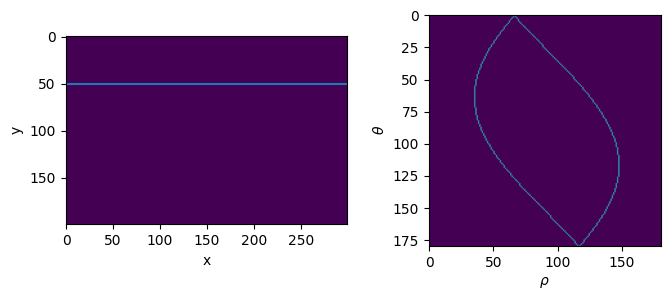

In [454]:
# Ejemplo 1
I = np.zeros((200, 300), dtype=np.uint8)
I[50, 50] = 255
I[50, 250] = 255

m = 180
n = int(np.ceil(np.sqrt(I.shape[0] ** 2 + I.shape[1] ** 2) / 2))
minimo_votos = 1
L = lineas_hough(I, m, n, minimo_votos)
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
show_acumulador(get_acumulador_hough(I, m, n), ax[1])
show_lineas(I, L, ax[0])
plt.show()

La idea base en la transformada de Hough (lineal) es transformar el dominio de la imagen al dominio de los parametros de rectas. Es decir
\begin{equation}
y_i = m x_i + n \Longrightarrow n_i = -m_i x + y
\end{equation}
Entonces de cierta forma conseguimos asignar a cada punto del domino de parametros una recta del dominio de la imagen.
En este nuevo dominio vamos a tener que la linea $n_i = -m_ix + y$ representa a todas las lineas que pasan por el punto $(x, y)$ del dominio inicial.

Como por dos puntos pasa una unica linea, cuando dos puntos del dominio de la imagen esten alineados vamos a encontrar que existe un unico par de rectas en el dominio de parametros que se intersectaran en cierto punto $(n, m)$.

Esto es a lo que nos referimos con un **voto**, **si el acumulador tiene en su entrada $(n_i, m_i)$ 100 votos esto quiere decir que hay 100 puntos en el dominio de la imagen alineados sobre la recta de parametros $(n_i, m_i)$**.

Una ultima observacion a tener en cuenta es que con la representacion usual de la recta la pendiente m, $-\infty \le m \le \infty$, y esto es un problema dado que implicaria la necesidad de tener un acumulador de largo potencialmente infinito en por lo menos una de las dimensiones. Por esto se utilizan coordenadas polares donde ahora

$$
\rho = x*\cos {\theta }+y*\sin {\theta }, \theta \in [0, 2\pi), \rho \ge 0
$$

> Nota: Ademas es facil ver que como $\rho$ es la distancia de la linea al origen, podremos establecer una cota superior tambien para este parametro.

Bibliografia

-   https://www.youtube.com/watch?v=XRBc_xkZREg
-   https://es.wikipedia.org/wiki/Transformada_de_Hough


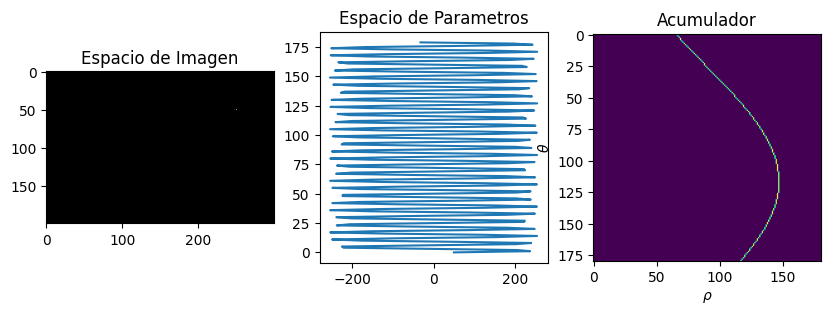

In [277]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
I = np.zeros((200, 300), dtype=np.uint8)
point = (50, 250)
I[point] = 255
ax[0].set_title("Espacio de Imagen")
ax[0].imshow(I, cmap="gray")
ax[1].set_title("Espacio de Parametros")
ax[1].plot(line(x=point[0], y=point[1])(thetas), thetas)
ax[2].set_title("Acumulador")
show_acumulador(get_acumulador_hough(I, m, n), ax[2])
plt.show()

En conclusion, siendo el eje y del acumulador la discretizacion de valores de $\theta$ y el eje x la discretizacion de valores de $\rho$, en el acumulador veremos un voto sobre todas las combinaciones $(\theta_i, \rho_i)$ tal que $\rho_i = x * cos(\theta_i) + y * sin(\theta_i)$


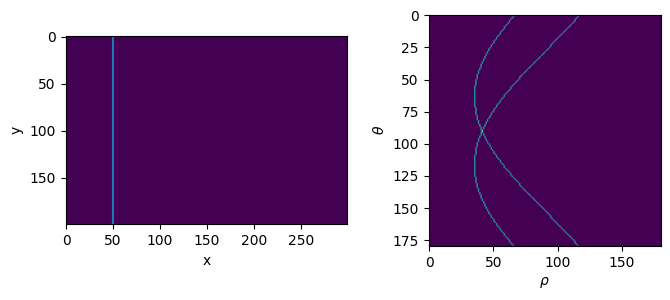

In [456]:
# Ejemplo 2
I = np.zeros((200, 300), dtype=np.uint8)
I[50, 50] = 255
I[150, 50] = 255

n = int(np.ceil(np.sqrt(I.shape[0] ** 2 + I.shape[1] ** 2) / 2))
minimo_votos = 1
L = lineas_hough(I, 180, n, minimo_votos)
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
show_acumulador(get_acumulador_hough(I, 180, n), ax[1])
show_lineas(I, L, ax[0])
plt.show()

En esta imagen, al tener dos puntos efectivamente existira una recta que contenga a ambos.

Los parametros de dicha recta los podremos ver en la interseccion de las curvas que vemos en el acumulador.

Cada una de esas curvas corresponde a todas las combinaciones (discretas) de parametros $(theta, rho)$ que contienen a su respectivo punto de la imagen, por ende el punto de interseccion de las curvas corresponde a la unica combinacion de parametros que define a la recta que contiene a los dos puntos de la imagen.

Tambien es facil ver que dicho punto tendra dos votos, uno por cada punto de la imagen


In [366]:
acum = get_acumulador_hough(I, 180, n)
votes = np.max(acum)
idx = np.unravel_index(np.argmax(acum), acum.shape)
print(f"Interseccion. (theta, rho) = ({idx[0]}, {idx[1]}), votos: {votes}")

Interseccion. (theta, rho) = (90, 41), votos: 2.0


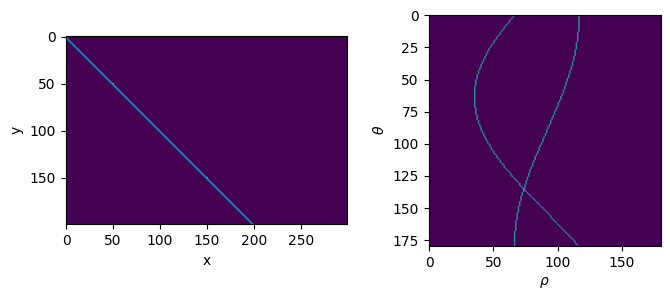

In [388]:
# Ejemplo 3
I = np.zeros((200, 300), dtype=np.uint8)
I[50, 50] = 255
I[150, 150] = 255

n = int(np.ceil(np.sqrt(I.shape[0] ** 2 + I.shape[1] ** 2) / 2))
minimo_votos = 1
L = lineas_hough(I, 180, n, minimo_votos)
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
show_acumulador(get_acumulador_hough(I, 180, n), ax[1])
show_lineas(I, L, ax[0])
plt.show()

In [389]:
acum = get_acumulador_hough(I, 180, n)
votes = np.max(acum)
idx = np.unravel_index(np.argmax(acum), acum.shape)
print(f"Interseccion. (theta, rho) = ({idx[0]}, {idx[1]}), votos: {votes}")

Interseccion. (theta, rho) = (135, 73), votos: 2.0


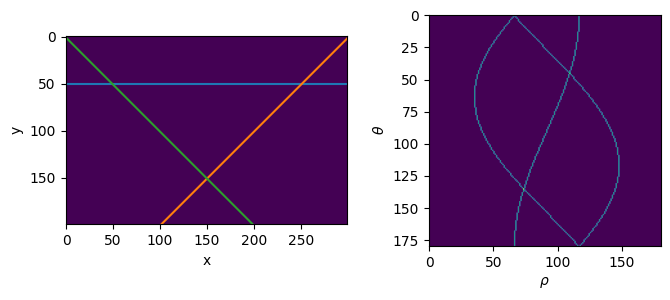

In [463]:
# Ejemplo 4
I = np.zeros((200, 300), dtype=np.uint8)
I[50, 50] = 255
I[50, 250] = 255
I[150, 150] = 255

n = int(np.ceil(np.sqrt(I.shape[0] ** 2 + I.shape[1] ** 2) / 2))
minimo_votos = 1
L = lineas_hough(I, 180, n, minimo_votos)
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
show_acumulador(get_acumulador_hough(I, 180, n), ax[1])
show_lineas(I, L, ax[0])
plt.show()

In [446]:
acum = get_acumulador_hough(I, 180, n)
idxs = list(zip(*np.unravel_index(np.argwhere(acum.flat == 2), acum.shape)))
for x, y in idxs:
    print(f"Interseccion. (theta, rho) = ({x}, {y}), votos: {acum[x,y]}")

Interseccion. (theta, rho) = ([0], [66]), votos: [2.]
Interseccion. (theta, rho) = ([45], [109]), votos: [2.]
Interseccion. (theta, rho) = ([135], [73]), votos: [2.]


En este ejemplo (al menos en los ángulos) se puede apreciar la correspondencia existente.

Tenemos una línea azul horizontal correspondiente al ángulo $\theta = 0$

Tenemos una línea roja correspondiente al ángulo $\theta = 45$

Tenemos una línea verde correspondiente al ángulo $\theta = 135$

Respecto al párametro rho es más complicado verlo dado que hicimos una traslación de coordenadas para llevar el origen al centro de la imagen, además de centrarlo sobre el índice del acumulador, etc.


#### Mostrar el funcionamiento de lineas_hough sobre la imagen trapecio.png

Comentar resultados al variar la resolución en el espacio de parámetros (m y n en la función lineas_hough)


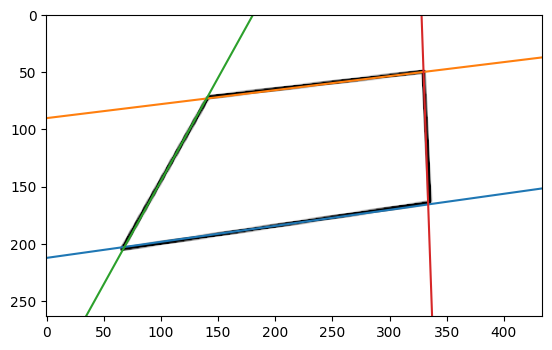

In [155]:
bin_img = np.where(trapecio <= 1, 1, 0)

n = int(np.ceil(np.sqrt(bin_img.shape[0] ** 2 + bin_img.shape[1] ** 2) / 2))
minimo_votos = 100
L = lineas_hough(bin_img, 180, n, minimo_votos)

plt.figure()
plt.imshow(trapecio, cmap="gray")
plot_lineas_hough(plt.gca(), L)

### 5. Aplicación: Segmentación de imágenes de documentos


En esta parte se usará un subset de la base RVL-CDIP que contiene imágenes de documentos escaneados.
https://adamharley.com/rvl-cdip/

Utilizando herramientas vistas en el curso (ej. análisis en frecuencia, transformaciones geométricas, segmentación por umbral, detección de bordes, lineas y regiones, morfología, etiquetado de regiones, entre otros) se buscará identificar en cada imagen:

**Tareas**

1. Orientación general del documento en la imagen. ¿El documento está en formato vertical o está apaisado?
2. Ángulo de giro. Ángulo a girar el documento en sentido horario para que las líneas y/o texto queden horizontales.
3. ¿El documento es un formulario o tabla? Se entenderá por formulario o tabla un documento que cuente con algunas líneas verticales y horizontales.
4. ¿El documento tiene columnas de texto? El documento tiene agrupaciones de texto en columnas por varias filas.
5. Límites horizontales del documento. Indicar la columna de inicio y fin del núcleo principal del documento. En caso que (4) sea afirmativo, indicar también las posiciones horizontales que separan las columnas de texto.
6. Alto de líneas. Distancia vertical en píxeles entre la línea de base de una fila y la de la siguiente.
7. Ancho de letra. En los casos que el documento tenga un tipo de letra "monospaced" (https://en.wikipedia.org/wiki/Monospaced_font) se podrá determinar el ancho de letra como la distancia horizontal en píxeles entre el comienzo de una letra y de la siguiente.
8. ¿El documento es sólo texto y/o líneas o contiene alguna figura? Se entenderá por figura un conjunto conexo de píxeles mayor al 1% del área de la imagen y que no está compuesto por texto/líneas y que tampoco es una región quasi-uniforme (ej. un rectángulo quasi-uniforme no se considera una figura)

En el pdf adjunto a este notebook hay ejemplos de las imágenes de documentos y de los resultados esperados para cada una de las tareas.


**Herramientas**  
Para la resolución de esta parte se podrá usar funciones de numpy, scipy, scikit-image, de OpenCV y herramientas de Fiji.

**Resultados esperados**

-   El problema se plantea en forma abierta y por lo tanto no hay una forma única de resolver cada tarea. La idea es que exploren las distintas técnicas y algoritmos vistos a lo largo del curso sobre un problema concreto
-   El conjunto de imágenes que les dejamos disponibles tiene cierta variabilidad por lo que, para las distintas tareas, habrá algunas imágenes más complicadas que otras. No esperen un funcionamiento perfecto de sus soluciones.
-   Para cada tarea implementada,
    -   se valorará que comenten él o los posibles métodos que la podrían resolver, antes de realizar una implementación concreta
    -   implementen alguno de esos métodos en la función cuyo esqueleto le pasamos. Pueden hacer funciones auxiliares si lo necesitan. Alternativamente pueden hacer un procedimiento o una macro si usan Fiji.
    -   muestren tests de su método sobre algunas imágenes
    -   opcionalmente pueden mostrar, si la tarea lo permite, resultados cuantitativos sobre el conjunto de imágenes (por ejemplo el porcentaje de acierto)
    -   comenten en qué casos funciona y qué casos son difíciles para el método (no es necesario un listado exhaustivo)
-   Implementaciones
    -   No se espera que un método implementado para una tarea funcione para todas o casi todas las imágenes.
    -   Las tareas tienen diferente dificultad. Para algunas será más sencillo hacer un método general y para otras se podrá hacer algo que funcione para un conjunto más restringido de imágenes. Hagan métodos no muy extensos, los testean y discuten resultados.
    -   Realizar al menos 5 de las 8 tareas


In [2]:
import pandas as pd

read_doc = lambda doc_name: cv2.imread(
    f"{dir_base_documentos}/{doc_name}", cv2.IMREAD_GRAYSCALE
)

ground_truth = pd.read_csv(
    f"{dir_base_documentos}/E2_ej5_datos_ground_truth.csv", index_col=0
)

In [3]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm


class Pipeline:
    def __init__(self, *functions_list):
        self.functions_list = functions_list

    def execute(self, data):
        data_id, data = data
        for f in self.functions_list:
            data = f(data)
        return data_id, data

    def parallel_execute(self, data_list):
        with ProcessPoolExecutor() as executor:
            results = list(
                tqdm(executor.map(self.execute, data_list), total=len(data_list))
            )
        return results

In [4]:
def get_confusion_matrix_values(df, feature="orientacion_vertical"):
    true_pos = (df["prediction"] == 1) & (df[feature] == 1)
    false_pos = (df["prediction"] == 1) & (df[feature] == 0)
    true_neg = (df["prediction"] == 0) & (df[feature] == 0)
    false_neg = (df["prediction"] == 0) & (df[feature] == 1)

    return df[true_pos], df[false_pos], df[true_neg], df[false_neg]


def calculate_metrics(tp, tn, fp, fn):
    total = tp + tn + fp + fn
    accuracy = (tp + tn) / total if total != 0 else 0

    positives = tp + fp
    precision = tp / positives if positives != 0 else 0

    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

    f1_score = (
        2 * (precision * recall) / (precision + recall)
        if (precision + recall) != 0
        else 0
    )

    return accuracy, precision, recall, f1_score, specificity


def print_metrics(accuracy, precision, recall, f1_score, specificity):
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall (Sensibilidad): {recall:.2f}")
    print(f"F1-Score: {f1_score:.2f}")
    print(f"Specificity: {specificity:.2f}")

##### 5.1 Orientación general


Discusión de métodos, pruebas


Para determinar la orientación del documento en la imagen podemos seguir los siguientes pasos:

1. Convertir la imagen a escala de grises si no lo esta.
1. Binarizar la imagen.
1. Aplicar la transformada de Hough para detectar lineas en la imagen.
1. Contar el número de líneas horizontales y verticales detectadas.
1. Si hay más líneas verticales que horizontales, el documento está orientado verticalmente, en caso contrario, el documento está orientado apaisado.

Una alternativa puede ser considerar la MTF de la imagen en vez de la imagen misma, si tomamos como valido el supuesto razonable de que el patron predominante en la imagen es generado por el texto, entonces podriamos estimar la orientacion del texto, y por ende, del documento detectando propiedades en el espectro de magnitud de la imagen.


Implementación


In [33]:
def MTF(doc):
    return np.log(np.abs(np.fft.fftshift(np.fft.fft2(doc))) + 1)


def normalize(doc):
    minimo = np.min(doc)
    return (doc - minimo) / (np.max(doc) - minimo)


def binarize(x):
    return np.where(x >= 0.5, 1, 0)


estimate_n = lambda doc: int(
    np.ceil(np.sqrt(doc.shape[0] ** 2 + doc.shape[1] ** 2) / 2)
)

In [8]:
def cuenta(lines):
    degs = np.rad2deg([line[0] for line in lines])
    # Separar las líneas horizontales de las verticales. deg deberia ser un angulo entre 0 y 180
    hor = np.array([deg for deg in degs if 45 <= deg <= 135])
    ver = np.array([deg for deg in degs if 0 <= deg < 45 or 180 >= deg > 135])
    # Calcular el número de líneas horizontales y verticales
    num_hor, num_ver = len(hor), len(ver)
    return num_hor, num_ver


def tiene_orientacion_vertical(I_doc):
    """
    Determina la orientación del documento en la imagen.

    Args:
    -----
    I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    orientacion_vertical (bool): Orientación del documento, puede ser 'vertical' (True) o 'apaisado' (False)
    """
    # Normalizar y Binarizar la Transformada de Fourier
    bin_fft = binarize(normalize(MTF(I_doc)))
    # Aplicar la transformada de Hough para detectar las 50 líneas mas dominantes
    lines = lineas_hough(bin_fft, 180, estimate_n(bin_fft), -1)[:50]
    # Calcular el número de líneas horizontales y verticales
    num_hor, num_ver = cuenta(lines)
    # Determinar la orientación del documento
    return not (num_ver > num_hor)

###### Visualizacion de algunos casos de prueba


In [ ]:
seed = 0

random_vert = (ground_truth[ground_truth["orientacion_vertical"] == 1]).sample(
    n=10, random_state=seed
)
verticales = [(nom, read_doc(nom)) for nom in random_vert["nombre"].values]

random_hor = (ground_truth[ground_truth["orientacion_vertical"] == 0]).sample(
    n=10, random_state=seed
)
apaisados = [(nom, read_doc(nom)) for nom in random_hor["nombre"].values]

ejemplos_doc = [*verticales, *apaisados]

In [19]:
def lines_50(img):
    return lineas_hough(img, 180, estimate_n(img), -1)[:50]


pipe_50lineas = Pipeline(MTF, normalize, binarize, lines_50)
lineas_test_docs = pipe_50lineas.parallel_execute(ejemplos_doc)

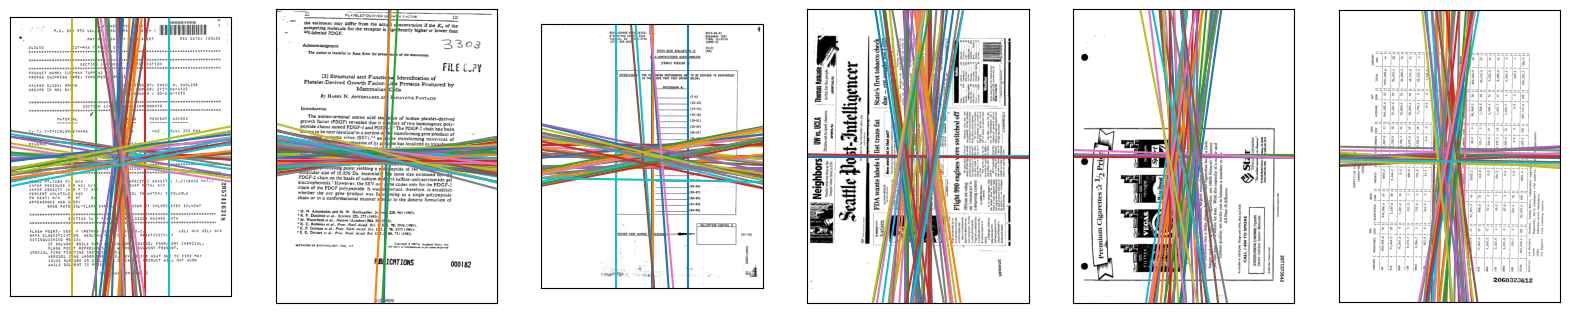

In [28]:
fig, ax = plt.subplots(1, 6, figsize=(20, 5), subplot_kw={"xticks": [], "yticks": []})
for a, (_, lineas), (_, doc) in zip(ax.flat, lineas_test_docs, ejemplos_doc):
    a.imshow(doc, cmap="gray")
    plot_lineas_hough(a, lineas)

De estos ejemplos se puede ver que la mayoria de rectas en la transformada siguen la inclinacion de las palabras, y por ende del documento.

Mas aun si contamos la mayoria de rectas (descartando las menos que van en el otro sentido), y calculamos alguna medida estadistica como el promedio o la moda de los angulos de dichas rectas podremos obtener una estimacion del angulo de giro.

Otra idea ademas es preprocesarla con algun filtro de deteccion de borde (analisis abajo).


###### Pruebas de Preprocesamiento con Filtros


100%|██████████| 5/5 [00:37<00:00,  7.43s/it]


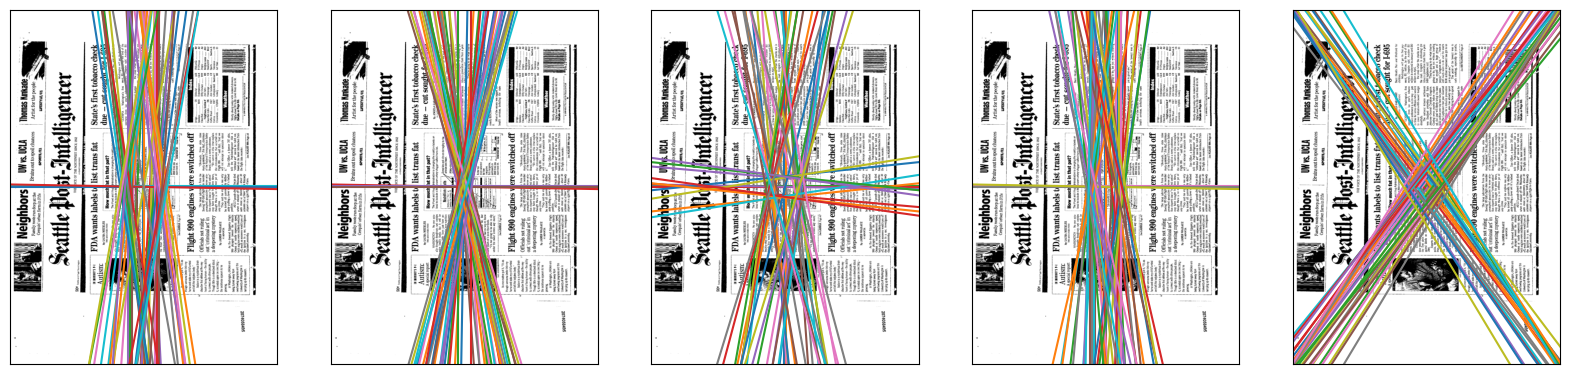

In [30]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5), subplot_kw={"xticks": [], "yticks": []})
_, doc = apaisados[0]

gaussian = cv2.GaussianBlur(doc, (21, 21), 0)
# filtro de edge detection, sharpen https://en.wikipedia.org/wiki/Kernel_(image_processing)
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharpen = cv2.filter2D(doc, -1, kernel)
# filtro de edge detection, ridge https://en.wikipedia.org/wiki/Kernel_(image_processing)
kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
ridge8 = cv2.filter2D(doc, -1, kernel)
# filtro de edge detection, ridge https://en.wikipedia.org/wiki/Kernel_(image_processing)
kernel = np.array([[-1, -1, -1], [-1, 4, -1], [-1, -1, -1]])
ridge4 = cv2.filter2D(doc, -1, kernel)

lineas = pipe_50lineas.parallel_execute(
    [("", doc), ("g", gaussian), ("s", sharpen), ("r8", ridge8), ("r4", ridge4)]
)
for ax, (_, l) in zip(ax.flat, lineas):
    ax.imshow(doc, cmap="gray")
    plot_lineas_hough(ax, l)

No parece que ninguno ofrezca una mejora sustancial.

El guassiano (imagen 2) parece centrar las lineas, lo que es interesante.

El filtro sharpen parece aumentar la varianza en la inclinacion de las rectas respecto de la original.

El filtro ridge 8 centra un poco las lineas.

El filtro ridge4 es claramente contraproducente.


###### Alternativas


In [138]:
def get_lineas(img):
    # evita crear el arreglo cada vez que se llama a la funcion, algo asi como una variable estatica
    # no demora mucho igual pero es un detalle
    if not hasattr(get_lineas, "theta_range"):
        get_lineas.theta_range = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)

    h, theta, d = skimage.transform.hough_line(img, theta=get_lineas.theta_range)
    # np.max(h.ravel())*K, K=0.2 se eligio arbitrariamente probando con distintos valores
    accum, angles, dists = skimage.transform.hough_line_peaks(
        h, theta, d, threshold=np.max(h.ravel()) * 0.2, num_peaks=50
    )
    return accum, angles, dists


def decide_mode(angles):
    most_common_angle = scipy.stats.mode(np.around(angles, decimals=1), keepdims=False)[
        0
    ]
    most_common_angle = np.rad2deg(most_common_angle)
    vertical = -45 <= most_common_angle <= 45
    # si hay mas lineas verticales quiere decir que hay mas letras en vertical, entonces esta apaisado
    return not vertical

In [7]:
def tiene_orientacion_vertical_1(I_doc):
    """solucion pero usando la implementacion de skimage de la transformada de hough
    * utiliza la mtf
    * elige como maximo las 50 lineas mas dominantes
    * decide segun la inclinacion mas frecuente"""
    bin_fft = binarize(normalize(MTF(I_doc)))

    _, angles, _ = get_lineas(bin_fft)

    return decide_mode(angles)


def tiene_orientacion_vertical_2(I_doc):
    """este no usa la transformada de fourier, aplica la transformada de hough sobre la imagen original luego
    de aplicado el filtro de bordes canny y ademas se estima la orientacion calculando el angulo mas frecuente
    * actua sobre los bordes de la imagen
    * elige como maximo las 50 lineas mas dominantes
    * decide segun la inclinacion mas frecuente"""
    # filtro de bordes canny sobre la imagen original
    edges = skimage.feature.canny(I_doc)

    _, angles, _ = get_lineas(edges)

    return decide_mode(angles)


def tiene_orientacion_vertical_3(I_doc):
    """solucion pero usando la implementacion de skimage de la transformada de hough
    * utiliza una porcion de alta frecuencia de la mtf
    * elige como maximo las 50 lineas mas dominantes
    * decide segun la inclinacion mas frecuente"""
    fshift = MTF(I_doc)
    crow, ccol = fshift.shape[0] // 2, fshift.shape[1] // 2
    # Filtrar el espectro de frecuencia
    fshift_filtered = fshift[crow - 30 : crow + 30, ccol - 30 : ccol + 30]
    # Normalizar y Binarizar la Transformada de Fourier
    bin_fft = binarize(normalize(fshift_filtered))

    _, angles, _ = get_lineas(bin_fft)

    return decide_mode(angles)

In [111]:
def plot_hough_skimage(I, lines, ax):
    ax.imshow(I, cmap="gray")
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    for _, angle, dist in lines:
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        deg = np.rad2deg(angle)
        if -45 <= deg <= 45:
            ax.axline((x0, y0), slope=np.tan(angle + np.pi / 2), color="r", alpha=0.2)
        else:
            ax.axline((x0, y0), slope=np.tan(angle + np.pi / 2), color="b", alpha=0.2)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


def lines_results(angles):
    ver = np.array([deg for deg in angles if -45 <= np.rad2deg(deg) <= 45])
    hor = np.array(
        [
            deg
            for deg in angles
            if -90 <= np.rad2deg(deg) < -45 or 45 < np.rad2deg(deg) <= 90
        ]
    )
    num_hor, num_ver = len(hor), len(ver)
    print(f"num_hor: {num_hor}, num_ver: {num_ver}, lines:{len(angles)}")

In [139]:
alg1 = Pipeline(tiene_orientacion_vertical_1)
alg2 = Pipeline(tiene_orientacion_vertical_2)
alg3 = Pipeline(tiene_orientacion_vertical_3)

###### Resultados sobre la base de documentos


In [37]:
all_docs = [(name, read_doc(name)) for name in ground_truth["nombre"]]

In [140]:
orientaciones_total_1 = alg1.parallel_execute(all_docs)
df_1 = pd.DataFrame(orientaciones_total_1, columns=["nombre", "prediction"]).merge(
    ground_truth[["nombre", "orientacion_vertical"]], on="nombre"
)

100%|██████████| 282/282 [00:52<00:00,  5.34it/s]


In [141]:
orientaciones_total_2 = alg2.parallel_execute(all_docs)
df_2 = pd.DataFrame(orientaciones_total_2, columns=["nombre", "prediction"]).merge(
    ground_truth[["nombre", "orientacion_vertical"]], on="nombre"
)

100%|██████████| 282/282 [00:49<00:00,  5.76it/s]


In [142]:
orientaciones_total_3 = alg3.parallel_execute(all_docs)
df_3 = pd.DataFrame(orientaciones_total_3, columns=["nombre", "prediction"]).merge(
    ground_truth[["nombre", "orientacion_vertical"]], on="nombre"
)

100%|██████████| 282/282 [00:13<00:00, 21.00it/s]


In [143]:
tp, fp, tn, fn = get_confusion_matrix_values(df_1)
print_metrics(*calculate_metrics(len(tp), len(tn), len(fp), len(fn)))

Accuracy: 0.87
Precision: 0.89
Recall (Sensibilidad): 0.97
F1-Score: 0.93
Specificity: 0.19


Este modelo no es malo pero tiene una tendencia a generar falsos positivos, es decir, a identificar documentos como verticales cuando no lo son. Dado que en el conjunto de documentos dominan los verticales esto no afecta mucho en el resto de las metricas.


In [144]:
tp, fp, tn, fn = get_confusion_matrix_values(df_2)
print_metrics(*calculate_metrics(len(tp), len(tn), len(fp), len(fn)))

Accuracy: 0.94
Precision: 1.00
Recall (Sensibilidad): 0.93
F1-Score: 0.97
Specificity: 1.00


Este modelo si tiene un buen funcionamiento.
Tiene una tasa de aciertos del 94% y dió falsos positivos en el conjunto de documentos.
Ademas logra un buen equilibrio entre precision y sensibilidad.


In [145]:
tp, fp, tn, fn = get_confusion_matrix_values(df_3)
print_metrics(*calculate_metrics(len(tp), len(tn), len(fp), len(fn)))

Accuracy: 0.68
Precision: 0.86
Recall (Sensibilidad): 0.76
F1-Score: 0.81
Specificity: 0.22


###### Visualizacion de algunos Resultados


In [150]:
def plot_results(preprocess_pipeline, df, idx=0):
    fig, ax = plt.subplots(
        1, 4, figsize=(10, 5), subplot_kw={"xticks": [], "yticks": []}
    )
    tipos = get_confusion_matrix_values(df)

    titles = ["TP", "FP", "TN", "FN"]
    for ax, tipo, title_type in zip(ax.flat, tipos, titles):
        if len(tipo) == 0:
            continue
        data_point = tipo.iloc[idx]
        img = read_doc(data_point["nombre"])
        _, bin_fft = preprocess_pipeline.execute(("", img))
        accum, angles, dists = get_lineas(bin_fft)
        plot_hough_skimage(img, zip(accum, angles, dists), ax)

        angle = np.rad2deg(
            scipy.stats.mode(np.around(angles, decimals=2), keepdims=False)[0]
        )
        ax.set_title(
            f"{title_type}: E={data_point['orientacion_vertical']} P={int(data_point['prediction'])}\nangle={angle:.4g}"
        )
        lines_results(angles)

    plt.show()

In [ ]:
def crop(fshift):
    crow, ccol = fshift.shape[0] // 2, fshift.shape[1] // 2
    return binarize(normalize(fshift[crow - 30 : crow + 30, ccol - 30 : ccol + 30]))


preprocess_mtf = Pipeline(MTF, normalize, binarize)
preprocess_canny = Pipeline(skimage.feature.canny)
preprocess_sub_mtf = Pipeline(MTF, crop, normalize, binarize)

num_hor: 19, num_ver: 24, lines:43
num_hor: 3, num_ver: 7, lines:10
num_hor: 5, num_ver: 14, lines:19
num_hor: 5, num_ver: 14, lines:19


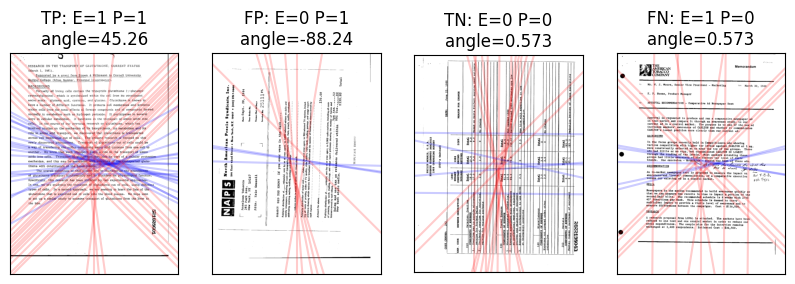

In [147]:
plot_results(preprocess_mtf, df_1, idx=0)

num_hor: 29, num_ver: 21, lines:50
num_hor: 8, num_ver: 42, lines:50
num_hor: 4, num_ver: 29, lines:33


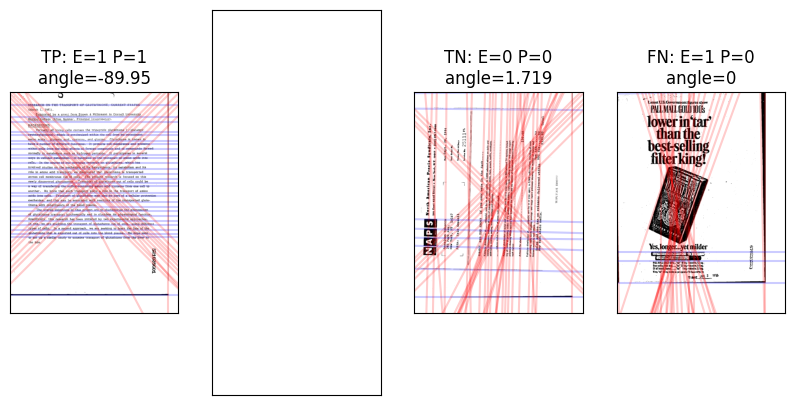

In [151]:
plot_results(preprocess_canny, df_2, idx=0)

num_hor: 10, num_ver: 8, lines:18
num_hor: 6, num_ver: 6, lines:12
num_hor: 8, num_ver: 16, lines:24
num_hor: 5, num_ver: 5, lines:10


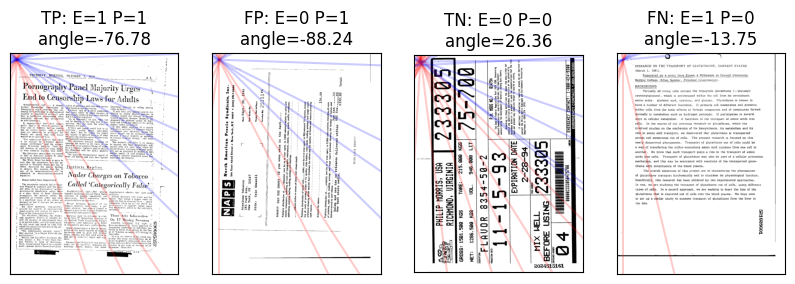

In [152]:
plot_results(preprocess_sub_mtf, df_3, idx=0)

> Nota: Las lineas graficadas en el ultimo ejemplo no quedan centradas porque fueron calculadas sobre una porcion del espectro de magnitud de tamano 30x30. Pero los resultados son equivalente a menos de un desplazamiento del centro.


##### 5.2 Ángulo de giro


Discusión de métodos, pruebas


1. Detectar los bordes del documento en la imagen utilizando técnicas de procesamiento de imágenes como la detección de bordes de Canny o la transformada de Hough.
1. Tomar alguna metrica util para estimar el angulo, como por ejemplo el angulo mas frecuente. Esto surge de asumir que la mayorias de lineas seran producto de los "renglones" de texto.


Implementación


In [43]:
def angulo_de_giro(I_doc):
    """
    Determina el ángulo (en grados) a girar la imagen en sentido horario
    para que las líneas y/o texto del documento queden horizontales.

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    angulo (double): ángulo en grados
    """
    edges = skimage.feature.canny(I_doc)
    # Transformada de Hough con angulos entre 0.1 - 180 degrees.
    # decimals_precision = 2 => precision 0.5 degrees
    # decimals_precision = k => precision 1/k degrees
    # por motivos de performance, se dejo en 1
    decimals_precision = 1
    tested_angles = np.deg2rad(np.linspace(0.1, 179.9, 180 * decimals_precision))
    # un treshold bajo nos asegura detectar bastantes lineas, eso hace que la moda sea un poco mas robusta
    h, theta, d = skimage.transform.hough_line(
        edges, theta=tested_angles, threshold=np.max(h) * 0.2
    )
    _, angles, _ = skimage.transform.hough_line_peaks(h, theta, d)

    # Angulo mas freuente
    most_common_angle = scipy.stats.mode(np.around(angles, decimals=2), keepdims=False)[
        0
    ]

    # Conversion
    skew_angle = np.rad2deg(most_common_angle - np.pi / 2)
    return skew_angle

In [3]:
def angle_based_on_hough(I_doc):
    edges = skimage.feature.canny(I_doc)
    tested_angles = np.deg2rad(np.linspace(0.1, 179.9, 180))
    h, theta, d = skimage.transform.hough_line(edges, theta=tested_angles)
    _, angles, _ = skimage.transform.hough_line_peaks(
        h, theta, d, threshold=np.max(h) * 0.2
    )
    most_common_angle = scipy.stats.mode(np.around(angles, decimals=2), keepdims=False)[
        0
    ]
    skew_angle = np.rad2deg(most_common_angle - np.pi / 2)
    return skew_angle

In [4]:
def angle_based_on_moment(image):
    """Digital Image Processing_ An Algorithmic Introduction Using Java, 235 page"""
    # Binarizar la imagen utilizando un umbral adecuado
    _, binary_image = cv2.threshold(
        image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )
    # Calculo de los momentos de la imagen binarizada
    moments = cv2.moments(binary_image)
    # Momentos centrados
    mu11, mu20, mu02 = moments["mu11"], moments["mu20"], moments["mu02"]
    # Calcular el ángulo de orientación
    angle = 0.5 * np.arctan2(2 * mu11, mu20 - mu02)
    return np.degrees(angle)

In [8]:
examples = ground_truth[["nombre", "angulo"]].sample(5, random_state=0).values
for nombre, angulo in examples:
    img = read_doc(nombre)
    hough_pred = angle_based_on_moment(img)
    mom_pred = angle_based_on_hough(img)
    print(
        f"{nombre}: Real={angulo:.3g} Angulo con Hough={hough_pred:3g} Angulo Basado en Momento={mom_pred:.3g}"
    )

2061012521.tif: Real=0.1 Angulo con Hough=59.7014 Angulo Basado en Momento=-0.619
2025537240.tif: Real=-2.3 Angulo con Hough=-80.4214 Angulo Basado en Momento=3.39
2046841409_2046841426.tif: Real=0.2 Angulo con Hough=63.8696 Angulo Basado en Momento=-0.619
50603083-3084.tif: Real=-0.1 Angulo con Hough=83.1235 Angulo Basado en Momento=0.527
CTRSP-FILES008286-82.tif: Real=-0.2 Angulo con Hough=86.5249 Angulo Basado en Momento=0.527


En estos pocos casos pareceria ser mas acertado el enfoque basado en momento.


Tests sobre imágenes


In [58]:
moment_pipe = Pipeline(angle_based_on_moment)
res_moment = moment_pipe.parallel_execute(
    [(nombre, read_doc(nombre)) for nombre in ground_truth["nombre"].values]
)

100%|██████████| 282/282 [00:02<00:00, 120.03it/s]


In [92]:
hough_pipe = Pipeline(angle_based_on_hough)
res_hough = hough_pipe.parallel_execute(
    [(nombre, read_doc(nombre)) for nombre in ground_truth["nombre"].values]
)

100%|██████████| 282/282 [01:14<00:00,  3.80it/s]


273


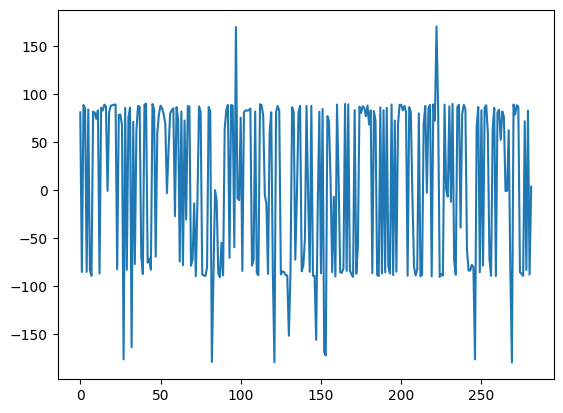

In [63]:
df_moment = pd.DataFrame(res_moment, columns=["nombre", "prediction"]).merge(
    ground_truth[["nombre", "angulo"]], on="nombre"
)

error_moment_df = df_moment.assign(diff=lambda df: df["prediction"] - df["angulo"])

error_moment_df["diff"].plot()

# cuantifico como error si el error en el angulo es mayor a 5 grado
print((error_moment_df["diff"].abs() > 5).sum())

Los resultados son bastante malos


34


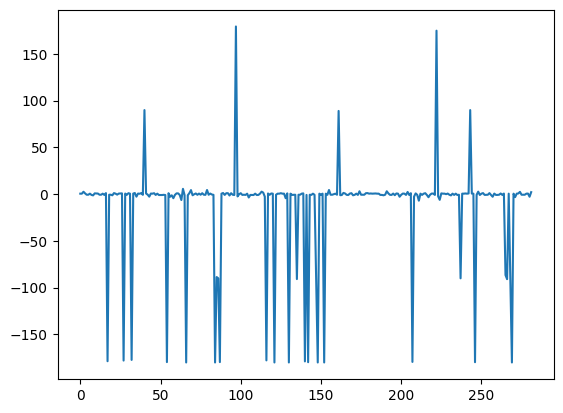

In [95]:
df_hough = pd.DataFrame(res_hough, columns=["nombre", "prediction"]).merge(
    ground_truth[["nombre", "angulo"]], on="nombre"
)

error_hough_df = df_hough.assign(diff=lambda df: df["prediction"] - df["angulo"])
error_hough_df["diff"].plot()

# cuantifico como error si el error en el angulo es mayor a 5 grados
print((error_hough_df["diff"].abs() > 5).sum())

Este parece andar mejor pero los resultados siguen sin ser tan buenos.


##### 5.3 Es un formulario o tabla ?


Discusión de métodos, pruebas


Podriamos buscar lineas sobre la imagen con la transformada de Hough y tratar de detectar si tenemos varias lineas horizontales (dentro de cierto rango) y varias verticales (tambien dentro de cierto rango) puesto que los formularios y tablas presentaran lineas de este estilo por las celdas de los formularios.

Un detalle a tener en cuenta es que habria que excluir las lineas horizontales y verticales producto de los bordes del documento.


Implementación


In [35]:
def es_tipo_tabla(I_doc):
    """
    Determina si el documento en la imagen es tipo formulario/tabla

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    es_tabla (bool): Verdadero si el documento en la imagen es tipo formulario/tabla
    """
    edges = cv2.Canny(I_doc, 100, 200)

    lines = cv2.HoughLines(edges, 1, np.pi / 180, 348)
    if lines is None:
        return False

    vert, horiz = 0, 0
    for line in lines:
        _, theta = line[0]
        if np.abs(theta - np.pi / 2) < np.pi / 6:
            vert += 1
        else:
            horiz += 1

    # heuristica: podria haber 2 lineas verticales y 2 horizontales producto de los bordes del documento
    # si hay mas de 2, probablemente sea una tabla o formulario
    return vert > 2 and horiz > 2

Tests sobre imágenes


In [36]:
all_docs = [(nombre, read_doc(nombre)) for nombre in ground_truth["nombre"].values]

In [37]:
pipe_form = Pipeline(es_tipo_tabla)
res_form = pipe_form.parallel_execute(all_docs)

100%|██████████| 282/282 [00:23<00:00, 11.85it/s]


In [38]:
df_form = pd.DataFrame(res_form, columns=["nombre", "prediction"]).merge(
    ground_truth[["nombre", "es_tabla"]], on="nombre"
)
tp, fp, tn, fn = get_confusion_matrix_values(df_form, feature="es_tabla")
print_metrics(*calculate_metrics(len(tp), len(tn), len(fp), len(fn)))

Accuracy: 0.82
Precision: 0.67
Recall (Sensibilidad): 0.27
F1-Score: 0.39
Specificity: 0.96


##### 5.4 ¿El documento tiene texto en columnas?


Discusión de métodos, pruebas


Podriamos intenar detectar los bloques, rectangulos correspondientes a las columnas de texto.

Entonces la regla de decision seria 2 o mas luego texto en columnas sino texto en una sola columna

> Nota: Hay que asegurarse de no captar otros bloques no sean del texto, fondos, titulos, figuras, etc.


In [8]:
def orientated_doc(name):
    angulo = ground_truth[ground_truth["nombre"] == name]["angulo"].values[0]
    img = read_doc(name)
    if angulo != 0:
        M = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), -angulo, 1)
        img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    return img

Implementación


In [118]:
def tiene_texto_en_columnas(I_doc):
    """
    Determina si el documento tiene texto en columnas

    Args:
    -----
      I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    tiene_columnas (bool): Verdadero en caso de tener columnas
    """
    edges = cv2.Canny(I_doc, 50, 150, apertureSize=3)

    lines = cv2.HoughLinesP(
        edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10
    )

    # Clasificar las líneas detectadas en verticales y horizontales
    vertical_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi

        # chequear si esta completamente vertical o en un entorno
        if np.isclose(angle, 90, atol=5) or np.isclose(angle, -90, atol=5):
            vertical_lines.append(line)

    # mas de 2 verticales excluyendo bordes del documento
    return len(vertical_lines) > 2

In [12]:
def has_columns(image):
    # eliminar pixeeles ruidosos
    blur_image = cv2.GaussianBlur(image, (5, 5), 0)
    _, threshold = cv2.threshold(
        blur_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
    )

    # https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
    # dilatamos para unir los renglones de texto en bloques, rectangulos
    dilated_image = cv2.dilate(src=threshold, kernel=kernel, iterations=1)

    # encontrar los bloques/contornos
    contours = cv2.findContours(
        image=dilated_image, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE
    )
    contours = contours[0] if len(contours) == 2 else contours[1]
    valid = 0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # heuristicas:
        # * la altura no debe ser mayor al 80% de la imagen ni menor a 50 pixeles
        # * el ancho no debe ser mayor al 50% de la imagen y no menor a 50 pixeles
        if image.shape[0] * 0.8 > h > 50 and image.shape[1] * 0.5 > w > 50:
            valid += 1

    return valid > 1

In [6]:
images_mcols = [
    nom
    for nom in ground_truth[ground_truth["tiene_columnas"] == 1]["nombre"]
    .sample(5, random_state=0)
    .values
]
images_1col = [
    nom
    for nom in ground_truth[ground_truth["tiene_columnas"] == 0]["nombre"]
    .sample(5, random_state=0)
    .values
]

In [120]:
def plot_contours(image_names):
    fig, ax = plt.subplots(1, 5, figsize=(20, 15))
    for name, a in zip(image_names, ax):
        ## observar que se esta corrigiendo la orientacion y angulo del documento
        angulo = ground_truth[ground_truth["nombre"] == name]["angulo"].values[0]
        img = read_doc(name)
        if angulo != 0:
            M = cv2.getRotationMatrix2D(
                (img.shape[1] / 2, img.shape[0] / 2), -angulo, 1
            )
            img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

        blur_image = cv2.GaussianBlur(img, (5, 5), 0)
        _, threshold = cv2.threshold(
            blur_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
        )
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
        dilated_image = cv2.dilate(src=threshold, kernel=kernel, iterations=1)

        contours = cv2.findContours(
            image=dilated_image, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE
        )
        contours = contours[0] if len(contours) == 2 else contours[1]
        contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[0])
        valid = 0
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if img.shape[0] * 0.8 > h > 100 and img.shape[1] * 0.5 > w > 50:
                valid += 1
                rect = plt.Rectangle(
                    (x, y), w, h, edgecolor=(1, 0, 0), linewidth=2, facecolor="none"
                )
                a.add_patch(rect)

        a.imshow(img, cmap="gray")
        a.set_title(f"Columnas: {valid} Pred: {valid>1}")

    plt.show()

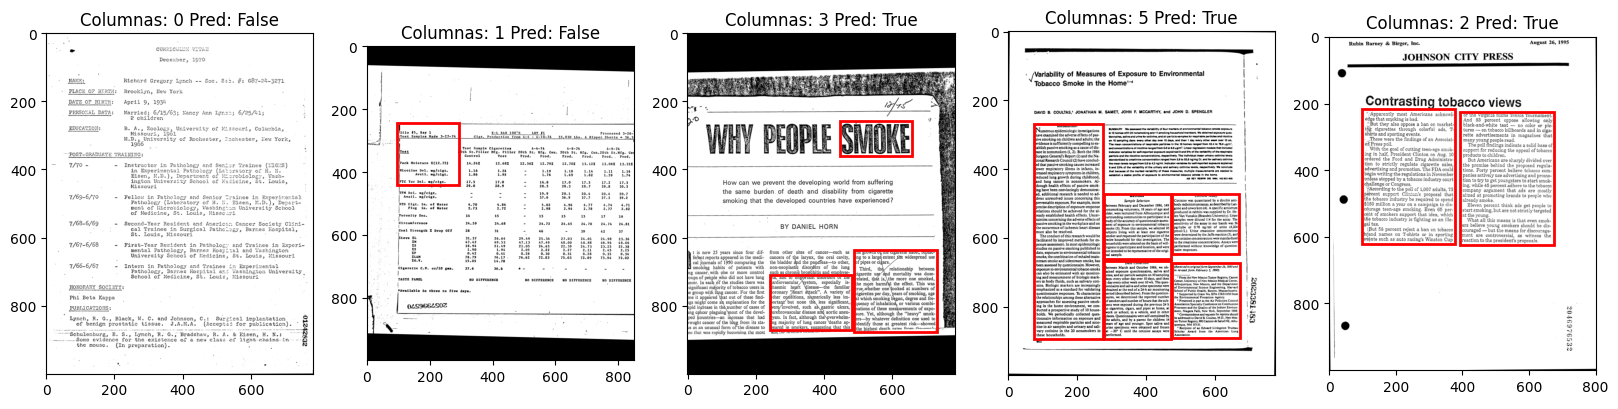

In [121]:
plot_contours(images_mcols)

Vemos que el algoritmo a veces logra lo cometido, pero tiene varios inconvenientes.


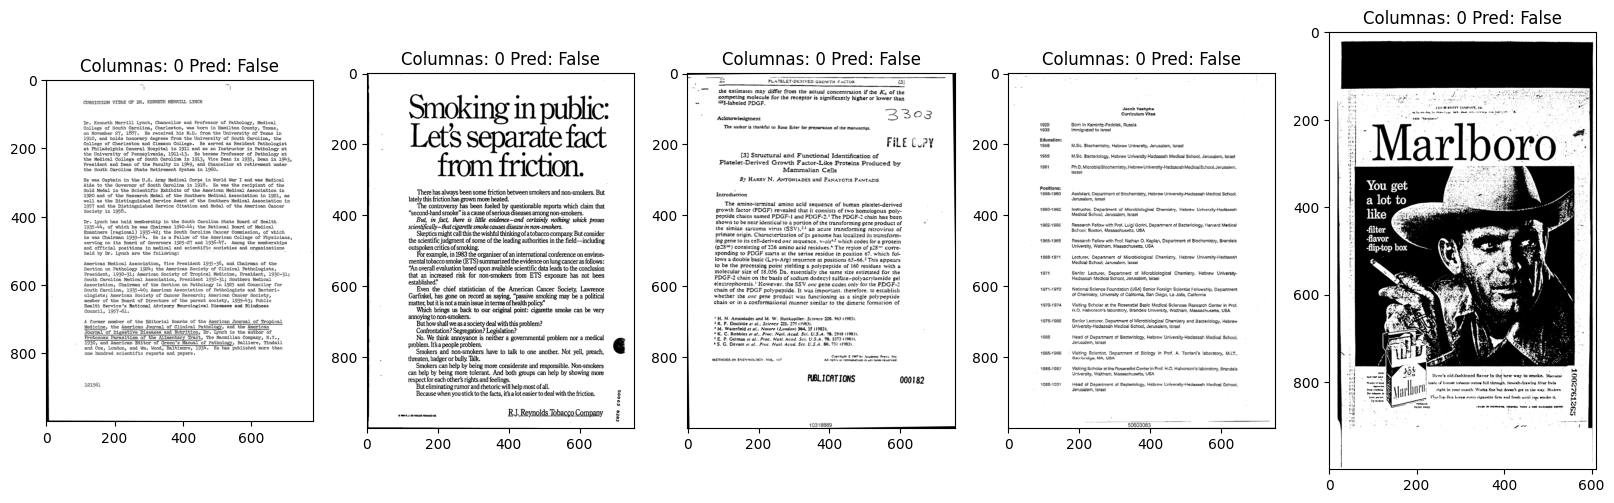

In [122]:
plot_contours(images_1col)

En estos ejemplos no observamos ningun falso negativo.

Probablemente la condicion: $img.shape[1]*0.5 > w > 50$ este jugando un rol importante dado que no estaremos contando contornos de ancho mayor al tamano de imagen, esto proviene de la observacion de que si tenemos dos columnas entonces $w_{col} < w_{doc} < w_{img}$.

Sin embargo, tambien es una condicion bastante restrictiva y dependiente de la correcta orientacion de los documentos.


Tests sobre imágenes


In [9]:
images_orientated = [
    (nom, orientated_doc(nom)) for nom in ground_truth["nombre"].values
]

In [13]:
pipe_columns = Pipeline(has_columns)
res_columns = pipe_columns.parallel_execute(images_orientated)

100%|██████████| 282/282 [00:01<00:00, 146.26it/s]


In [15]:
df_columns = pd.DataFrame(res_columns, columns=["nombre", "prediction"]).merge(
    ground_truth[["nombre", "tiene_columnas"]], on="nombre"
)

tp, fp, tn, fn = get_confusion_matrix_values(df_columns, feature="tiene_columnas")
print_metrics(*calculate_metrics(len(tp), len(tn), len(fp), len(fn)))

Accuracy: 0.62
Precision: 0.56
Recall (Sensibilidad): 0.72
F1-Score: 0.63
Specificity: 0.54


Los resultados no son demasiado buenos.

Podemos probar otra estrategia como contar lineas verticales excluyendo los bordes del documento


In [16]:
def has_columns_2(image):
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(
        edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10
    )
    vertical_lines = 0
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        if np.isclose(angle, 90, atol=5) or np.isclose(angle, -90, atol=5):
            vertical_lines += 1
    return vertical_lines > 2

In [17]:
pipe_columns_2 = Pipeline(has_columns_2)
res_columns_2 = pipe_columns_2.parallel_execute(images_orientated)

100%|██████████| 282/282 [00:37<00:00,  7.54it/s]


In [18]:
df_columns_2 = pd.DataFrame(res_columns_2, columns=["nombre", "prediction"]).merge(
    ground_truth[["nombre", "tiene_columnas"]], on="nombre"
)

tp, fp, tn, fn = get_confusion_matrix_values(df_columns_2, feature="tiene_columnas")
print_metrics(*calculate_metrics(len(tp), len(tn), len(fp), len(fn)))

Accuracy: 0.53
Precision: 0.49
Recall (Sensibilidad): 0.86
F1-Score: 0.62
Specificity: 0.26


El anterior modelo funcionaba mejor


##### 5.8 ¿El documento contiene figuras?


Discusión de métodos, pruebas


Podemos tratar de identificar las componentes conexas de la imagen que cumplan con ciertos requisitos deseables (area mayor al 1% del area de la imagen, no ser quasi-uniforme, etc.)


Implementación


In [40]:
def tiene_alguna_figura(I_doc):
    """
    Determina si el documento tiene alguna figura

    Args:
    -----
    I_doc (2D array): imagen con un documento escaneado.

    Returns:
    --------
    tiene_figura (bool): Verdadero en caso de tener alguna figura
    """
    # binarizar la imagen
    _, binary_image = cv2.threshold(
        I_doc, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
    )

    # detectar componentes conexas
    connectivity = 4
    num_labels, _, stats, _ = cv2.connectedComponentsWithStats(
        binary_image, connectivity, cv2.CV_32S
    )

    image_area = I_doc.shape[0] * I_doc.shape[1]
    # para cada componente validarla o no como figura
    for label in range(1, num_labels):
        area = stats[label, cv2.CC_STAT_AREA]
        width = stats[label, cv2.CC_STAT_WIDTH]
        height = stats[label, cv2.CC_STAT_HEIGHT]

        aspect_ratio = height / width if width > 0 else 0

        # area supera 1% del area de la imagen
        # el aspect_ratio lo usamos para excluir formas rectangulares largas por ejemplo
        # lineas de texto o bordes mal escaneados.
        if (area > 0.01 * image_area) and (0.25 < aspect_ratio < 4):
            return True

    return False

Tests sobre imágenes


In [187]:
pipe_figures = Pipeline(tiene_alguna_figura)
figures_res = pipe_figures.parallel_execute(
    [(nom, read_doc(nom)) for nom in ground_truth["nombre"]]
)
features = ["tiene_figura", "tiene_figura_ext"]
df_figures = pd.DataFrame(figures_res, columns=["nombre", "prediction"]).merge(
    ground_truth[["nombre"] + features], on="nombre"
)

100%|██████████| 282/282 [00:04<00:00, 62.68it/s] 


In [245]:
tp, fp, tn, fn = get_confusion_matrix_values(df_figures, feature="tiene_figura")
print_metrics(*calculate_metrics(len(tp), len(tn), len(fp), len(fn)))
print()
tp, fp, tn, fn = get_confusion_matrix_values(df_figures, feature="tiene_figura_ext")
print_metrics(*calculate_metrics(len(tp), len(tn), len(fp), len(fn)))

Accuracy: 0.77
Precision: 0.30
Recall (Sensibilidad): 0.87
F1-Score: 0.44
Specificity: 0.76

Accuracy: 0.80
Precision: 0.52
Recall (Sensibilidad): 0.75
F1-Score: 0.61
Specificity: 0.81


In [170]:
def visualize_components(img):
    threshold = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    num_labels, label_ids, stats, _ = cv2.connectedComponentsWithStats(
        threshold, 4, cv2.CV_32S
    )
    accepted, rejected = (
        np.zeros(img.shape, dtype=np.uint8),
        np.zeros(img.shape, dtype=np.uint8),
    )
    image_area = img.shape[0] * img.shape[1]
    for label in range(1, num_labels):
        area = stats[label, cv2.CC_STAT_AREA]
        width = stats[label, cv2.CC_STAT_WIDTH]
        height = stats[label, cv2.CC_STAT_HEIGHT]
        aspect_ratio = width / height if height > 0 else 0
        if (area > 0.01 * image_area) and (0.25 < aspect_ratio < 4):
            componentMask = (label_ids == label).astype(np.uint8) * 255
            accepted = cv2.bitwise_or(accepted, componentMask)
        else:
            componentMask = (label_ids == label).astype(np.uint8) * 255
            rejected = cv2.bitwise_or(rejected, componentMask)
    return accepted, rejected

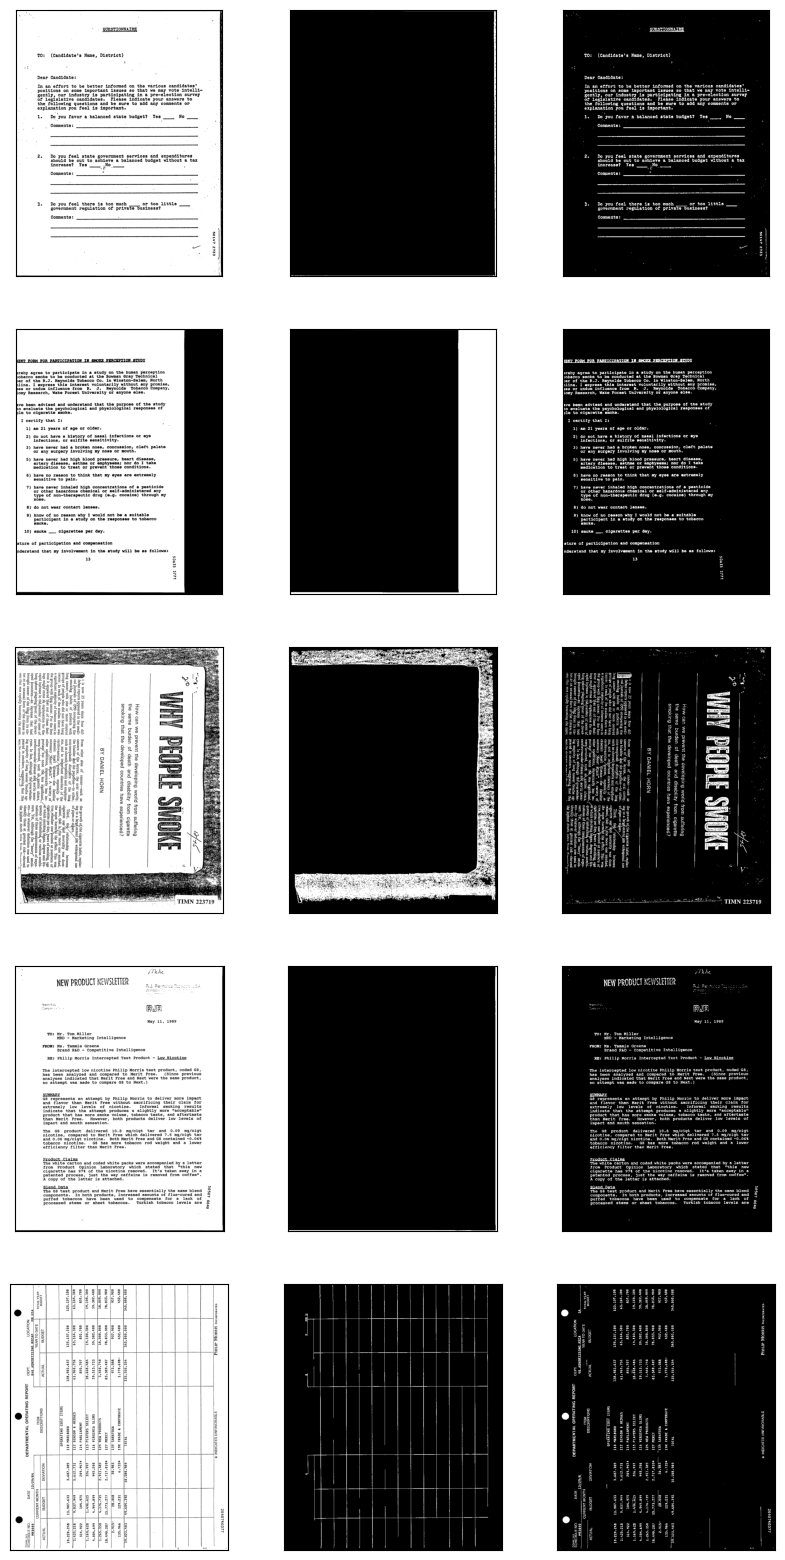

In [246]:
# Visualizacion de algunos falsos positivos
n_samples = 5
samples_names = (
    df_figures[
        (df_figures["prediction"] == True) & (df_figures["tiene_figura"] == False)
    ]["nombre"]
    .sample(n_samples, random_state=0)
    .values
)
fig, ax = plt.subplots(
    n_samples, 3, figsize=(10, 4 * n_samples), subplot_kw={"xticks": [], "yticks": []}
)

for ax_row, name in zip(ax, samples_names):
    img = read_doc(name)
    accepted, rejected = visualize_components(img)
    ax_row[0].imshow(img, cmap="gray")
    ax_row[1].imshow(accepted, cmap="gray")
    ax_row[2].imshow(rejected, cmap="gray")

plt.show()

Viendo algunos ejemplos de falsos positivos, podemos ver que estamos detectando ciertos rectangulos que no deberiamos.

Por ejemplo en el tercer ejemplo el problema viene dado por capturar el fondo de la imagen, algo ajeno al documento.
Podriamos intentar borrar el fondo previamente.

Por otro lado, la ultima tiene esas lineas finas de las celdas que tampoco deberiamos detectar. Dada su escaso grosor podriamos tratar de eliminarlas realizando un proceso de erosion.


In [261]:
def has_figures_2(image):
    """analogo pero eliminando el fondo con operaciones morfologicas"""
    _, binary_image = cv2.threshold(
        image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
    )

    # Open = erosion seguido de dilatacion. Util para remover ruido o figuras muy pequenas, en nuestro caso las celdas vistas
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

    connectivity = 4
    num_labels, _, stats, _ = cv2.connectedComponentsWithStats(
        binary_image, connectivity, cv2.CV_32S
    )
    image_area = img.shape[0] * img.shape[1]
    for label in range(1, num_labels):
        area = stats[label, cv2.CC_STAT_AREA]
        width = stats[label, cv2.CC_STAT_WIDTH]
        height = stats[label, cv2.CC_STAT_HEIGHT]
        aspect_ratio = width / height if height > 0 else 0
        if (area > 0.01 * image_area) and (0.25 < aspect_ratio < 4):
            return True
    return False

In [262]:
def visualize_components_2(img):
    threshold = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    threshold = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel)

    num_labels, label_ids, stats, _ = cv2.connectedComponentsWithStats(
        threshold, 4, cv2.CV_32S
    )
    accepted = np.zeros(img.shape, dtype=np.uint8)
    rejected = np.zeros(img.shape, dtype=np.uint8)
    image_area = img.shape[0] * img.shape[1]
    for label in range(1, num_labels):
        area = stats[label, cv2.CC_STAT_AREA]
        width = stats[label, cv2.CC_STAT_WIDTH]
        height = stats[label, cv2.CC_STAT_HEIGHT]
        aspect_ratio = width / height if height > 0 else 0
        if (area > 0.01 * image_area) and (0.25 < aspect_ratio < 4):
            componentMask = (label_ids == label).astype(np.uint8) * 255
            accepted = cv2.bitwise_or(accepted, componentMask)
        else:
            componentMask = (label_ids == label).astype(np.uint8) * 255
            rejected = cv2.bitwise_or(rejected, componentMask)
    return accepted, rejected

In [242]:
pipe_figures_2 = Pipeline(has_figures_2)
figures_res_2 = pipe_figures_2.parallel_execute(
    [(nom, read_doc(nom)) for nom in ground_truth["nombre"]]
)

features = ["tiene_figura", "tiene_figura_ext"]
df_figures_2 = pd.DataFrame(figures_res_2, columns=["nombre", "prediction"]).merge(
    ground_truth[["nombre"] + features], on="nombre"
)

100%|██████████| 282/282 [00:04<00:00, 70.17it/s]


In [258]:
df_figures_2[df_figures_2["nombre"].isin(samples_names)]

nombre  prediction  tiene_figura  tiene_figura_ext
82     2040740377_2040740392.tif       False             0                 0
177                501472733.tif       False             0                 0
193                505070648.tif       False             0                 0
203                506353771.tif        True             0                 0
281  tob09504.65_tob09504.70.tif       False             0                 1

De los ejemplos de Falsos Positivos vistos anteriormente logramos corregir varios.

Logramos corregir el caso de la deteccion de las celdas que no deseabamos ('2040740377_2040740392.tif').

Sin embargo, no conseguimos corregir la detccion del fondo oscuro del escaneo ('506353771.tif').


In [243]:
tp, fp, tn, fn = get_confusion_matrix_values(df_figures_2, feature="tiene_figura")
print_metrics(*calculate_metrics(len(tp), len(tn), len(fp), len(fn)))
print()
tp, fp, tn, fn = get_confusion_matrix_values(df_figures_2, feature="tiene_figura_ext")
print_metrics(*calculate_metrics(len(tp), len(tn), len(fp), len(fn)))

Accuracy: 0.90
Precision: 0.53
Recall (Sensibilidad): 0.70
F1-Score: 0.60
Specificity: 0.92

Accuracy: 0.87
Precision: 0.80
Recall (Sensibilidad): 0.53
F1-Score: 0.64
Specificity: 0.96


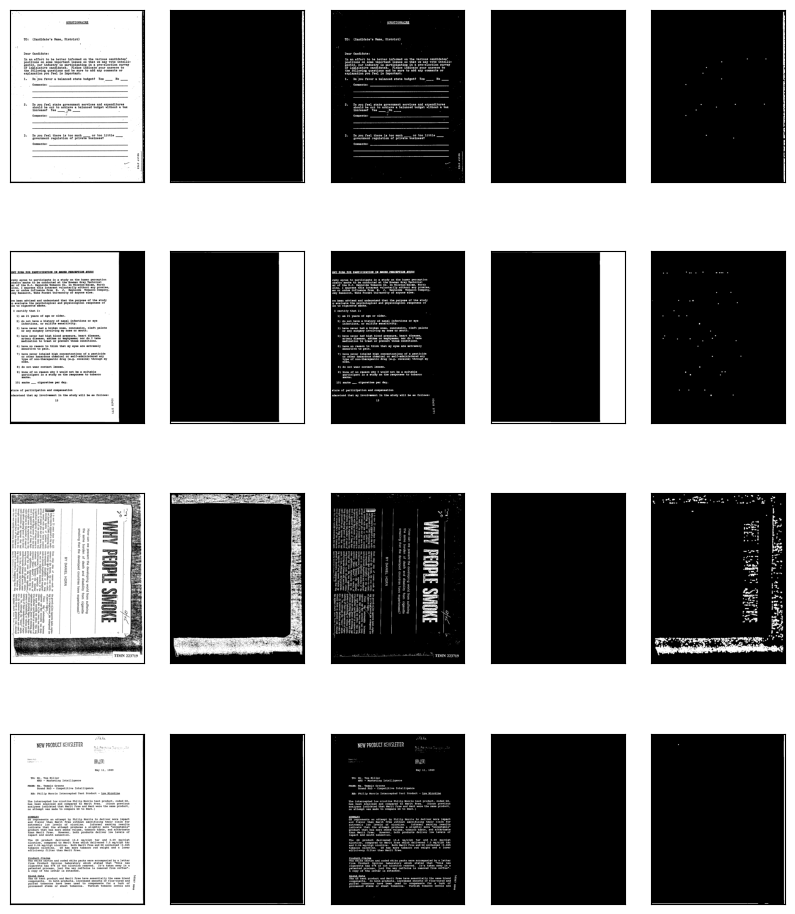

In [264]:
# Visualizacion de diferencias entre los metodos, flasos positivos del metodo 1 que ahora son claisificados como negativos satisfactoriamente
n_samples = 4
feature = "tiene_figura_ext"

fp_1 = df_figures[(df_figures["prediction"] == True) & (df_figures[feature] == False)]
tn_2 = df_figures_2[
    (df_figures_2["prediction"] == False) & (df_figures_2[feature] == False)
]
improvements = tn_2.merge(fp_1, on="nombre", how="inner")

samples = improvements["nombre"].sample(n_samples, random_state=1).values
fig, ax = plt.subplots(
    n_samples, 5, figsize=(10, 3 * n_samples), subplot_kw={"xticks": [], "yticks": []}
)

for ax_row, name in zip(ax, samples_names):
    img = read_doc(name)
    ax_row[0].imshow(img, cmap="gray")
    accepted, rejected = visualize_components(img)
    ax_row[1].imshow(accepted, cmap="gray")
    ax_row[2].imshow(rejected, cmap="gray")
    accepted, rejected = visualize_components_2(img)
    ax_row[3].imshow(accepted, cmap="gray")
    ax_row[4].imshow(rejected, cmap="gray")

plt.show()

In [329]:
def has_figure3(image):
    # thresholding
    _, binary_image = cv2.threshold(
        image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
    )

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
        binary_image, connectivity=8
    )

    total_area = image.shape[0] * image.shape[1]
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        width = stats[i, cv2.CC_STAT_WIDTH]
        height = stats[i, cv2.CC_STAT_HEIGHT]
        aspect_ratio = width / height if height > 0 else 0
        # se agrego la funcion que chequea si la componente es quasi uniforme basasdo en sus pixeles
        if (
            (area > 0.01 * total_area)
            and (0.25 < aspect_ratio < 4)
            and not is_quasi_uniform(image, labels, i)
        ):
            return True

    return False


def is_quasi_uniform(image, labels, label):
    # obtenemos la regio o componente
    region = (labels == label).astype(np.uint8)

    # calculo del desvio estandar
    std_dev = np.std(image[region == 1])

    # si los valores de los pixeles de la region son muy similares, entonces el desvio estandar sera bajo
    # esto no lo queremos dado que podrian ser rectangulos del fondo por ejemplo
    return std_dev <= 5

In [327]:
pipe3 = Pipeline(has_figure3)
res3 = pipe3.parallel_execute([(nom, read_doc(nom)) for nom in ground_truth["nombre"]])

100%|██████████| 282/282 [00:03<00:00, 88.06it/s] 


In [328]:
# morph added + aspect ratio
features = ["tiene_figura", "tiene_figura_ext"]
df_figures_3 = pd.DataFrame(res3, columns=["nombre", "prediction"]).merge(
    ground_truth[["nombre"] + features], on="nombre"
)

tp, fp, tn, fn = get_confusion_matrix_values(df_figures_3, feature="tiene_figura")
print_metrics(*calculate_metrics(len(tp), len(tn), len(fp), len(fn)))
print()
tp, fp, tn, fn = get_confusion_matrix_values(df_figures_3, feature="tiene_figura_ext")
print_metrics(*calculate_metrics(len(tp), len(tn), len(fp), len(fn)))

Accuracy: 0.91
Precision: 0.55
Recall (Sensibilidad): 0.70
F1-Score: 0.62
Specificity: 0.93

Accuracy: 0.87
Precision: 0.82
Recall (Sensibilidad): 0.52
F1-Score: 0.63
Specificity: 0.97


In [331]:
df_figures_3[df_figures_3["nombre"] == "506353771.tif"]

nombre  prediction  tiene_figura  tiene_figura_ext
203  506353771.tif       False             0                 0

Finalmente pudimos corregir el documento mal escaneado, aunque en general el modelo no mejoro sustancialmente comparado con el anterior.
